In [1]:
library(tidyverse)
library(patchwork)
library(Seurat)
library(ggpubr)
library(Signac)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect




In [2]:
charm = readRDS("../1_preprocess/charm.rds")

In [3]:
charm[[]] %>% summary()

     orig.ident    nCount_rna     nFeature_rna   nCount_atac    nFeature_atac  
 CHARMmesc:805   Min.   : 1141   Min.   : 921   Min.   :10141   Min.   : 9296  
                 1st Qu.:14194   1st Qu.:4903   1st Qu.:44758   1st Qu.:37830  
                 Median :17163   Median :5432   Median :52302   Median :43706  
                 Mean   :17610   Mean   :5397   Mean   :52162   Mean   :43543  
                 3rd Qu.:20903   3rd Qu.:6028   3rd Qu.:59825   3rd Qu.:49531  
                 Max.   :38602   Max.   :8015   Max.   :79385   Max.   :64714  
                                                                               
   nCount_ct       nFeature_ct     TSS.enrichment.atac TSS.percentile.atac
 Min.   : 20610   Min.   : 18706   Min.   :2.407       Min.   :0.0300     
 1st Qu.: 87615   1st Qu.: 69648   1st Qu.:3.228       1st Qu.:0.3200     
 Median :103765   Median : 81305   Median :3.563       Median :0.5500     
 Mean   :106481   Mean   : 82132   Mean   :3.572       Mean 

## 1. 和其他方法对比检测效率

In [4]:
# re-format CHARM metadata to "cell	nCounts	nFeatures	Method	Cell_line	Modality"
reformat_CHARM_metadata = rbind(
    charm@meta.data %>% mutate(Method = "This study",Cell_line = "mESC",Modality = "RNA") %>%
         dplyr::select(cellname, nCount_rna, nFeature_rna,Method,Cell_line,Modality) %>% rename("nCounts"="nCount_rna", "nFeatures"="nFeature_rna","cell"="cellname"),
    charm@meta.data %>% mutate(Method = "This study",Cell_line = "mESC",Modality = "ATAC") %>%
         dplyr::select(cellname,nCount_atac, nFeature_atac,Method,Cell_line,Modality) %>% rename("nCounts"="nCount_atac", "nFeatures"="nFeature_atac","cell"="cellname"),
    charm@meta.data %>% mutate(Method = "This study",Cell_line = "mESC",Modality = "H3K27me3") %>%
         dplyr::select(cellname,nCount_ct, nFeature_ct,Method,Cell_line,Modality) %>% rename("nCounts"="nCount_ct", "nFeatures"="nFeature_ct","cell"="cellname"),
    charm@meta.data %>% mutate(Method = "This study",Cell_line = "mESC",Modality = "Hi-C",nFeatures = NA) %>%
         dplyr::select(cellname,Method,Cell_line,Modality,nFeatures,pairs_clean3) %>% rename("nCounts"="pairs_clean3","cell"="cellname")
)
head(reformat_CHARM_metadata)

,cell,nCounts,nFeatures,Method,Cell_line,Modality
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>
P10001,P10001,15803,5527,This study,mESC,RNA
P10002,P10002,15513,5461,This study,mESC,RNA
P10003,P10003,17669,5653,This study,mESC,RNA
P10004,P10004,20129,6085,This study,mESC,RNA
P10005,P10005,19544,6163,This study,mESC,RNA
P10006,P10006,16437,5468,This study,mESC,RNA


In [38]:
# load public data
issaac_seq_res = read_csv("/shareb/zliu/analysis/CHARM/publicData/issaac-seq/ISSAAC-seq/cell_lines_metrics.csv")
dpt_res = read_tsv("/shareb/zliu/analysis/CHARM/publicData//droplet_pairtag/Droplet_PairedTag_reformat_metadata.tsv")
coTECH_res = read_tsv("/shareb/zliu/analysis/CHARM/publicData/coTECH/coTECH_reformat_metadata.tsv") %>% mutate(Method = "CoTECH")
HiRES_res = readxl::read_excel("/sharec/zliu/HiRES/hires_mouse_dev//submission/submitfiles/HiRES_emb_metadata.xlsx")
chair_res = readxl::read_excel("./public_data/41592_2025_2658_MOESM14_ESM.xlsx", sheet = 1) %>% suppressWarnings()
chair_res = chair_res %>% select(cellid,nCounts,nFeatures,Method,Cell_line,Modality)
names(chair_res)[1] = "cell"
rbind(
HiRES_res %>% mutate(cell = Cellname,Method = "HiRES",Cell_line = "mouse embryo",Modality = "RNA",nCounts = `UMI counts`,nFeatures = `Genes number`) %>%
         dplyr::select(cell,nCounts,nFeatures,Method,Cell_line,Modality),
HiRES_res %>% mutate(cell = Cellname,Method = "HiRES",Cell_line = "mouse embryo",Modality = "Hi-C",nCounts = `Clean3 contacts`,nFeatures = NA) %>%
         dplyr::select(cell,nCounts,nFeatures,Method,Cell_line,Modality)
) -> HiRES_res
limca_res = read_tsv("./public_data/limca.tsv") %>% filter(Cell_line %in% c("GM12878","MOE"))
gageseq_res = read_tsv("./public_data/gageseq/gageseq.tsv")

Rows: 142096 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (4): cell, Method, Cell_line, Modality
dbl (2): nCounts, nFeatures

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8765 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (4): cell, Method, Cell_line, Modality
dbl (2): nCounts, nFeatures

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6690 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (4): cell, Method, Cell_line, Modality
dbl (2): nCounts, nFeatures

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_ty

In [40]:
# #cols = c('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a')
cols = c("#bdbdbd","#bdbdbd", "#bdbdbd", "#bdbdbd","#bdbdbd", "#bdbdbd","#bdbdbd","#bdbdbd", "#bdbdbd", "#cb181d")
# #"ISSAAC-seq (FACS) E14", "10x Multiome E14","SNARE-seq H1","SHARE-seq NIH3T3","sci-CAR-seq HEK293T","Paired-seq HEK293T","coTECH mESC","Droplet Paired-Tag mESC","HiRES mouse embryo","CHARM mESC"
methods_colors = c("ISSAAC-seq (FACS) E14" = cols[1],"10x Multiome E14" = cols[2],"SNARE-seq H1" = cols[3],"SHARE-seq NIH3T3" = cols[4],"sci-CAR-seq HEK293T" = cols[5],"Paired-seq HEK293T" = cols[6],
                   "CoTECH mESC" = cols[7],"Droplet Paired-Tag mESC" = cols[8],"HiRES mouse embryo" = cols[9],"ChAIR K562" = cols[9],"ChAIR patski" = cols[9],
                   "GAGE-seq NIH3T3"= cols[9],"GAGE-seq mBcortex"= cols[9],"LiMCA GM12878"= cols[9],"LiMCA Olfactory"= cols[9],"This study mESC" = cols[9])


In [21]:
# options(repr.plot.width=3, repr.plot.height=4,repr.plot.res=200)

# selected_methods = c("ISSAAC-seq (FACS) E14","10x Multiome E14","This study mESC")
# rbind(chair_res,reformat_CHARM_metadata) %>% mutate(label = paste0(Method," ",Cell_line)) %>% 
#      filter(label %in% selected_methods) %>% 
#      filter(nCounts > 1000, Modality == "ATAC") %>% 
#     ggviolin(x="label",y="nCounts",fill="label",palette = methods_colors,size=0) +
#     geom_boxplot(width=0.2, outlier.shape = NA) +
#     scale_y_log10() + xlab("") + ylab("Accessible fragments") + 
#     theme(axis.text.x = element_text(angle = 25, hjust = 1)) + 
#     scale_x_discrete(expand = expansion(mult = c(0.2, 0.1))) + NoLegend() -> p1

# p1 %>% ggsave(filename = "figures/CHARMmesc_ATAC_count_violin_subset.pdf",width=3,height=4)
# p1

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


label,count,median,mean,sd
<chr>,<int>,<dbl>,<dbl>,<dbl>
10x Multiome E14,8288,36579.5,37225.950,22449.0294
ChAIR K562,38015,5224.0,5441.589,2385.5470
ChAIR patski,35515,3124.0,3548.772,1738.6160
ISSAAC-seq (FACS) E14,375,24950.0,26336.112,10926.2229
Paired-seq HEK293T,724,1618.0,2641.878,3408.7730
SHARE-seq NIH3T3,1337,1748.0,2359.811,1871.1803
SNARE-seq H1,203,1660.0,1828.069,829.6344
This study mESC,805,52302.0,52161.636,11680.4380
sci-CAR-seq HEK293T,62,1360.0,1494.597,545.4000


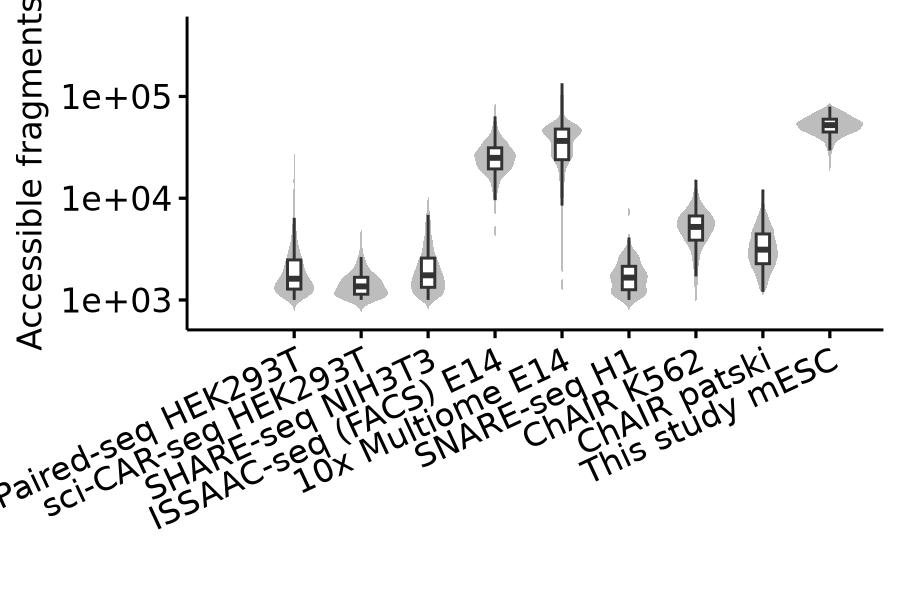

In [85]:
options(repr.plot.width=4.5, repr.plot.height=3,repr.plot.res=200)
rbind(chair_res,reformat_CHARM_metadata) %>% mutate(label = paste0(Method," ",Cell_line)) %>% 
     filter(label %in% names(methods_colors)) %>% 
     filter(nCounts > 1000, Modality == "ATAC") %>% 
    ggviolin(x="label",y="nCounts",fill="label",palette = methods_colors,size=0) +
    geom_boxplot(width=0.2, outlier.shape = NA) +
    scale_y_log10() + xlab("") + ylab("Accessible fragments") + 
    theme(axis.text.x = element_text(angle = 25, hjust = 1)) + 
    scale_x_discrete(expand = expansion(mult = c(0.2, 0.1))) + NoLegend() -> p1

p1 %>% ggsave(filename = "figures/CHARMmesc_ATAC_count_violin_full.pdf",width=4.5,height=3)
p1

rbind(chair_res,reformat_CHARM_metadata) %>% mutate(label = paste0(Method," ",Cell_line)) %>% 
     filter(label %in% names(methods_colors)) %>% 
     filter(nCounts > 1000, Modality == "ATAC") %>% 
     group_by(label) %>% summarise(count = n(),median = median(nCounts), mean = mean(nCounts),sd = sd(nCounts)) 

In [23]:
# options(repr.plot.width=3, repr.plot.height=4,repr.plot.res=200)
# selected_methods = c("HiRES mouse embryo","This study mESC")
# rbind(chair_res,dpt_res,coTECH_res,HiRES_res,reformat_CHARM_metadata) %>% mutate(label = paste0(Method," ",Cell_line)) %>% 
#      filter(label %in% selected_methods) %>% 
#      filter(nCounts > 1000, Modality == "RNA") %>% 
#     ggviolin(x="label",y="nCounts",fill="label",palette = methods_colors,size=0) +
#     geom_boxplot(width=0.2, outlier.shape = NA) +
#     scale_y_log10() + xlab("") + ylab("UMIs") + 
#     theme(axis.text.x = element_text(angle = 25, hjust = 1)) + 
#     scale_x_discrete(expand = expansion(mult = c(0.2, 0.1)))  + NoLegend() -> p1

# p1 %>% ggsave(filename = "figures/CHARMmesc_RNA_count_violin_subset.pdf",width=3,height=4)
# p1

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


label,count,median,mean,sd
<chr>,<int>,<dbl>,<dbl>,<dbl>
10x Multiome E14,8717,10955.0,12277.229,7735.4415
ChAIR K562,40060,4354.0,4607.836,2028.3554
ChAIR patski,35515,1772.0,1972.732,682.1264
CoTECH mESC,2984,2120.0,3284.010,3196.2747
Droplet Paired-Tag mESC,4191,2968.0,3944.133,2809.0535
GAGE-seq NIH3T3,568,14064.0,15749.162,8955.7810
GAGE-seq mBcortex,5062,20499.5,25088.060,22390.5964
HiRES mouse embryo,7415,9127.0,10000.901,4917.7200
ISSAAC-seq (FACS) E14,379,11039.0,12097.971,5739.8543


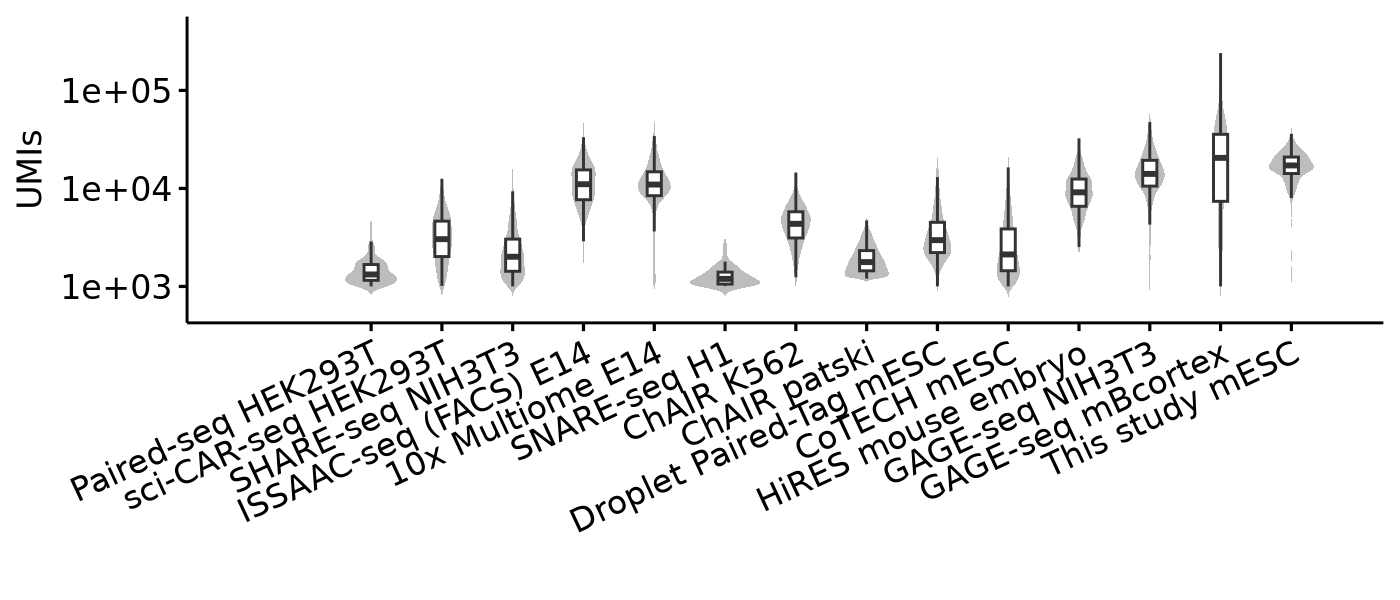

In [86]:
options(repr.plot.width=7, repr.plot.height=3,repr.plot.res=200)
rbind(chair_res,dpt_res,coTECH_res,HiRES_res,gageseq_res,reformat_CHARM_metadata) %>% mutate(label = paste0(Method," ",Cell_line)) %>% 
     filter(label %in% names(methods_colors)) %>% 
     filter(nCounts > 1000, Modality == "RNA") %>% 
    ggviolin(x="label",y="nCounts",fill="label",palette = methods_colors,size=0) +
    geom_boxplot(width=0.2, outlier.shape = NA) +
    scale_y_log10() + xlab("") + ylab("UMIs") + 
    theme(axis.text.x = element_text(angle = 25, hjust = 1)) + 
    scale_x_discrete(expand = expansion(mult = c(0.2, 0.1)))  + NoLegend() -> p1

p1 %>% ggsave(filename = "figures/CHARMmesc_RNA_count_violin_full.pdf",width=7,height=3)
p1

rbind(chair_res,dpt_res,coTECH_res,HiRES_res,gageseq_res,reformat_CHARM_metadata) %>% mutate(label = paste0(Method," ",Cell_line)) %>% 
     filter(label %in% names(methods_colors)) %>% 
     filter(nCounts > 1000, Modality == "RNA") %>% 
     group_by(label) %>% summarise(count = n(),median = median(nCounts), mean = mean(nCounts),sd = sd(nCounts))

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


label,count,median,mean,sd
<chr>,<int>,<dbl>,<dbl>,<dbl>
CoTECH mESC,2428,1852.5,2735.388,3324.656
Droplet Paired-Tag mESC,4174,3434.0,8071.121,17810.197
This study mESC,805,103765.0,106481.355,27661.876


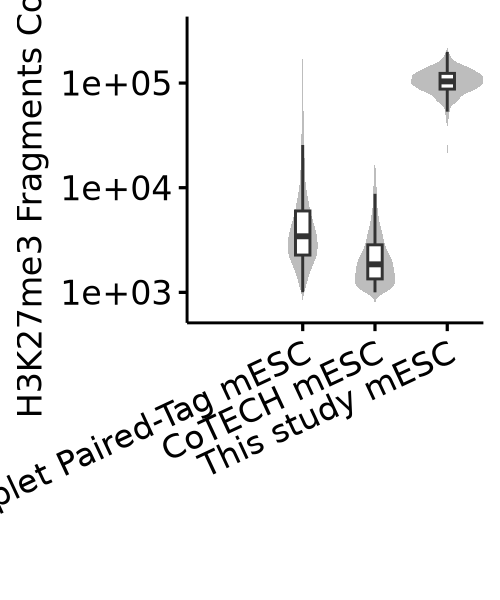

In [87]:
selected_methods = c("CoTECH mESC","Droplet Paired-Tag mESC","This study mESC")

options(repr.plot.width=2.5, repr.plot.height=3,repr.plot.res=200)

rbind(dpt_res,coTECH_res,reformat_CHARM_metadata) %>% dplyr::filter(nCounts > 1000,Modality == "H3K27me3") %>% 
    mutate(label = paste0(Method," ", Cell_line)) %>%
    filter(label %in% selected_methods) %>%
    ggviolin(x="label",y="nCounts",fill="label",palette = methods_colors,size=0) +
    geom_boxplot(width=0.2, outlier.shape = NA) + scale_y_log10() + 
    theme(axis.text.x = element_text(angle = 25, hjust = 1)) + 
    ylab("H3K27me3 Fragments Counts") + xlab("") + 
    scale_x_discrete(expand = expansion(mult = c(0.8, 0.1)))  + NoLegend() -> p1

p1 %>% ggsave(filename = "figures/CHARM_H3K27me3_Fragments_violin.pdf",width=2.5,height=3)
p1

rbind(dpt_res,coTECH_res,reformat_CHARM_metadata) %>% dplyr::filter(nCounts > 1000,Modality == "H3K27me3") %>% 
    mutate(label = paste0(Method," ", Cell_line)) %>%
    filter(label %in% names(methods_colors))  %>% group_by(label) %>%
    summarise(count = n(),median = median(nCounts), mean = mean(nCounts),sd = sd(nCounts))

In [44]:
charm_hic_contacts = reformat_CHARM_metadata %>% filter(Modality == "Hi-C") %>% select(nCounts) %>% mutate(method = "CHARM")
names(charm_hic_contacts) = c("contacts","method")
hires_hic_contacts = HiRES_res %>% filter(Modality == "Hi-C") %>% select(nCounts) %>% mutate(method = "HiRES")
names(hires_hic_contacts) = c("contacts","method")

In [47]:
set.seed(42)
pairs_path = dir("/sharec/zliu/archieve/else/research/publicData/tanay_cellcycle_alldata_2/result/cleaned_pairs/c12") %>% sample(100)
hic_contacts_nagano = lapply(pairs_path,function(x){
    tryCatch({
        read.table(file.path("/sharec/zliu/archieve/else/research/publicData/tanay_cellcycle_alldata_2/result/cleaned_pairs/c12",x),header = F) %>% nrow()
    },error = function(e){
        return(NA)
    })
}) %>% unlist() %>% data.frame(contacts = .,method = "scHi-C")

pairs_path = dir("/shareb/zliu/analysis/mouse_brain/Tan2020/pairs") %>% sample(100)
hic_contacts_dipc = lapply(pairs_path,function(x){
    tryCatch({
        read.table(file.path("/shareb/zliu/analysis/mouse_brain/Tan2020/pairs",x),header = F) %>% nrow()
    },error = function(e){
        return(NA)
    })
}) %>% unlist() %>% data.frame(contacts = .,method = "Dip-C")

In [48]:
read_tsv("./public_data/combine.tsv") %>% select(total_contacts,method) -> public_hic_contacts
names(public_hic_contacts) = c("contacts","method")

Rows: 283 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): method, celltype
dbl (3): total_contacts, intra, inter

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [68]:
gageseq_res_hic = gageseq_res %>% filter(Modality == "Hi-C") %>% 
    mutate(contacts = nCounts,method = paste0(Method," ",Cell_line)) %>% 
    column_to_rownames("cell") %>% select(contacts,method)

limca_res_hic = limca_res %>% filter(Modality == "Hi-C") %>% 
    mutate(contacts = nCounts,method = paste0(Method," ",Cell_line)) %>% 
    column_to_rownames("cell") %>% select(contacts,method)

In [73]:
limca_res_hic %>% pull(method) %>% unique()
gageseq_res_hic %>% pull(method) %>% unique()

[1] "LiMCA GM12878" "LiMCA MOE"

[1] "GAGE-seq NIH3T3"   "GAGE-seq mBcortex"

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


displayname,count,median,mean,sd
<chr>,<int>,<dbl>,<dbl>,<dbl>
Dip-C mouse brain,86,345017.5,350564.10,127674.33
Droplet Hi-C mouse brain,237,30714.0,36652.46,18532.34
HiRES mouse embryo,7469,267633.0,277541.66,103124.42
Nagano et al. scHi-C mESC (2017),84,137562.5,154326.06,115081.73
This study mESC,805,1853231.0,1747392.77,640193.88
snm3C-seq mESC,46,216747.5,315431.15,275180.85


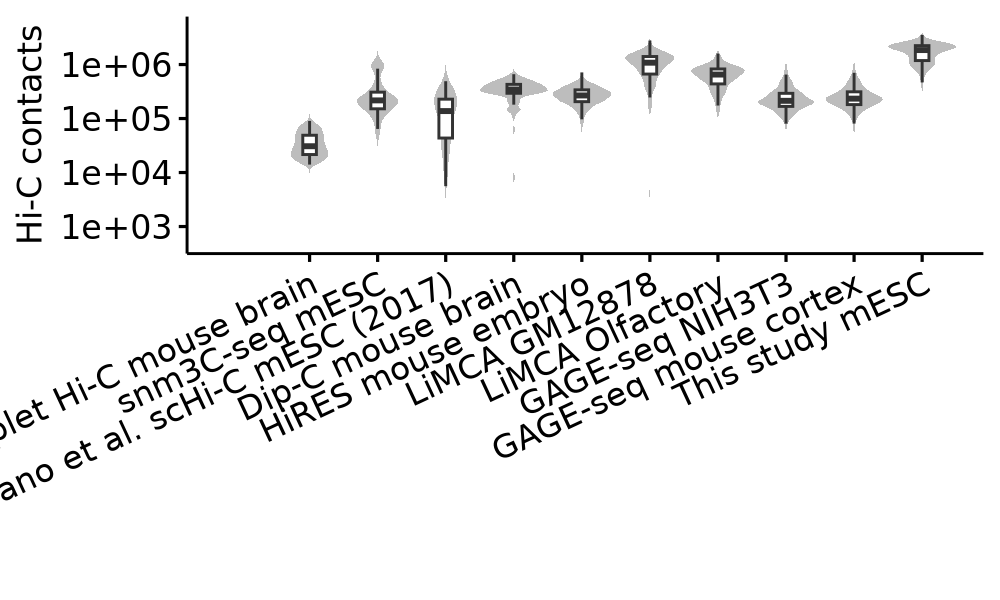

In [88]:
options(repr.plot.width=5, repr.plot.height=3,repr.plot.res=200)

xlab_name_conversion = c(
    "CHARM" = "This study mESC",
    "snm3c" = "snm3C-seq mESC",
    "Dip-C" = "Dip-C mouse brain",
    "scHi-C" = "Nagano et al. scHi-C mESC (2017)",
    "Droplet Hi-C" = "Droplet Hi-C mouse brain",
    "LiMCA GM12878" = "LiMCA GM12878",
    "LiMCA MOE" = "LiMCA Olfactory",
    "GAGE-seq NIH3T3" = "GAGE-seq NIH3T3",
    "GAGE-seq mBcortex" = "GAGE-seq mouse cortex",
    "HiRES" = "HiRES mouse embryo"
)
#palette = c("CHARM" = cols[10],"snm3c" = cols[8],"Dip-C" = cols[7],"scHi-C" = cols[6],"Droplet Hi-C" = cols[1])
palette = c("CHARM" = cols[9],"snm3c" = cols[8],"Dip-C" = cols[7],"scHi-C" = cols[6],"Droplet Hi-C" = cols[1],"HiRES" = cols[9],
            "LiMCA GM12878" = cols[9],"LiMCA MOE" = cols[9],
            "GAGE-seq NIH3T3" = cols[9],"GAGE-seq mBcortex" = cols[9])

rbind(charm_hic_contacts,public_hic_contacts,hic_contacts_nagano %>% na.omit() %>% filter(contacts > 5e3),
      hic_contacts_dipc %>% filter(contacts > 5e3),hires_hic_contacts%>% filter(contacts > 5e3),
      gageseq_res_hic,limca_res_hic) %>% 
    mutate(displayname = xlab_name_conversion[method])  %>%
    ggviolin(x="displayname",y="contacts",fill="method",palette = palette,size=0,
    order = c("Droplet Hi-C mouse brain","snm3C-seq mESC","Nagano et al. scHi-C mESC (2017)","Dip-C mouse brain","HiRES mouse embryo",
              "LiMCA GM12878","LiMCA Olfactory","GAGE-seq NIH3T3","GAGE-seq mouse cortex",
              "This study mESC")
    ) + 
    geom_boxplot(width=0.2,outlier.shape = NA) + scale_y_log10() +
    theme(axis.text.x = element_text(angle = 25, hjust = 1)) + NoLegend() + xlab("") + ylab("Hi-C contacts") + 
    scale_x_discrete(expand = expansion(mult = c(0.2, 0.1)))  + NoLegend() -> p1
p1
p1 %>% ggsave(filename="figures/CHARM_HiC_contacts_violin_all.pdf",width=5,height=3)


rbind(charm_hic_contacts,public_hic_contacts,hic_contacts_nagano %>% na.omit() %>% filter(contacts > 5e3),hic_contacts_dipc %>% filter(contacts > 5e3),hires_hic_contacts%>% filter(contacts > 5e3)) %>% 
    mutate(displayname = xlab_name_conversion[method])  %>%
    group_by(displayname) %>% summarise(count = n(),median = median(contacts), mean = mean(contacts),sd = sd(contacts))


In [75]:
# rbind(charm_hic_contacts,hires_hic_contacts%>% filter(contacts > 5e3)) %>% 
#     mutate(displayname = xlab_name_conversion[method])  %>%
#     ggviolin(x="displayname",y="contacts",fill="method",palette = palette,size=0,
#     order = c("HiRES mouse embryo","This study mESC"),
#     ) + 
#     geom_boxplot(width=0.2,outlier.shape = NA) + scale_y_log10() +
#     theme(axis.text.x = element_text(angle = 25, hjust = 1)) + NoLegend() + xlab("") + ylab("Hi-C contacts") + 
#     scale_x_discrete(expand = expansion(mult = c(0.2, 0.1)))  + NoLegend() -> p1

# options(repr.plot.width=3, repr.plot.height=4,repr.plot.res=200)
# p1
# p1 %>% ggsave(filename="figures/CHARM_HiC_contacts_violin_subset.pdf",width=3,height=4)

# 2. 和HiRES 的比较

In [174]:
hires=read_rds("/sharec/zliu/HiRES/hires_mouse_dev/submission/submitfiles/HiRES_embdev.rds")

In [178]:
hires[[]] %>% select(UMIs_exon,UMIs_gene) %>% colMeans()
charm_rawmetadata = read_tsv("/shareb/zliu/analysis/CHARM/CHARM_mesc/Rawdataprocess/enrich_new/metadata_raw.tsv") 
charm_rawmetadata %>% filter(cellname %in% rownames(charm[[]]))%>%  select(UMIs_gene,UMIs_exon) %>% colMeans()


UMIs_exon UMIs_gene 
 2598.513  9933.945

Rows: 959 Columns: 25
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr  (1): cellname
dbl (24): Rawreads, DNAreads, RNAreads, yperx, raw_pairs, pairs_dedup, pairs...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


UMIs_gene UMIs_exon 
17620.279  4126.714

In [179]:
print(2598 / 9933)
#print(7335 / 9933)
print(4126/17620)
#print(13540/17620)

[1] 0.2615524
[1] 0.2341657


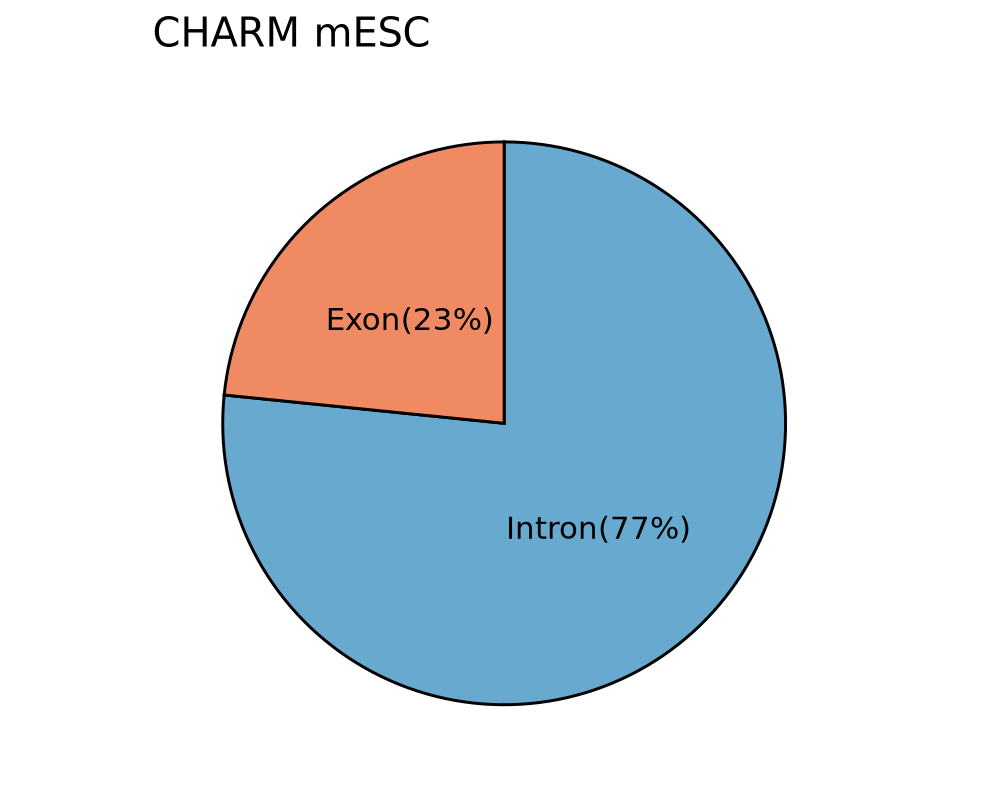

In [180]:
df_pie = data.frame(
    method = c("CHARM","CHARM","HiRES","HiRES"),
    type = c("Exon(23%)","Intron(77%)","Exon(26%)","Intron(74%)"),
    value = c(4135,13540,2598,7335)
)
ggpie(df_pie %>% filter(method=="CHARM"),"value",label = "type",fill="type",palette = c("#ef8a62","#67a9cf"),lab.pos = "in", lab.font = "black") + NoLegend() + ggtitle("CHARM mESC")
ggsave("figures/CHARM_mesc_UMI_pie.pdf",width=4,height=4)

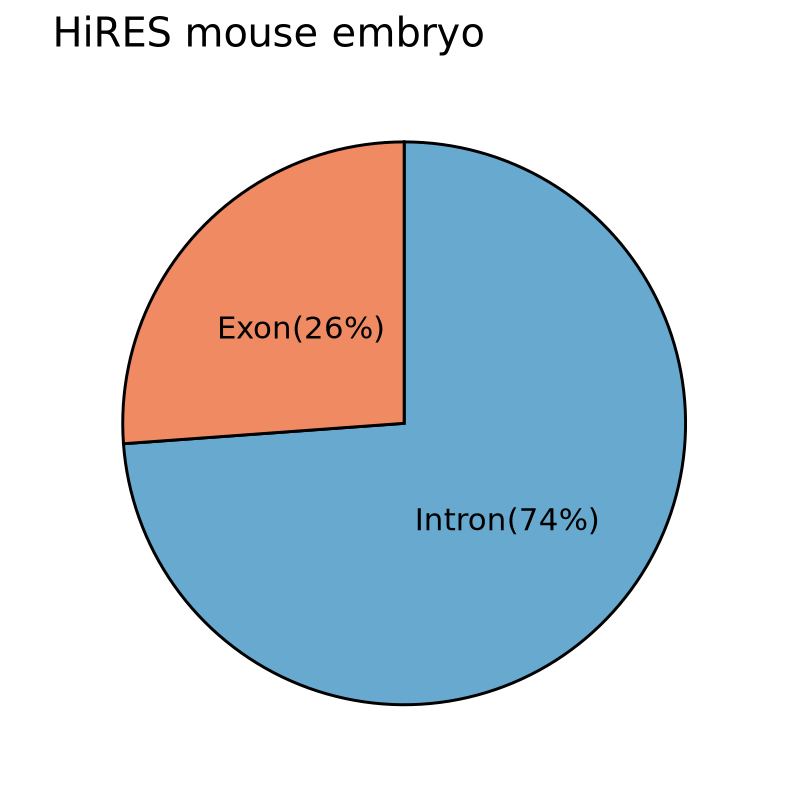

In [24]:
ggpie(df_pie %>% filter(method=="HiRES"),"value",label = "type",fill="type",palette = c("#ef8a62","#67a9cf"),lab.pos = "in", lab.font = "black") + NoLegend() + ggtitle("HiRES mouse embryo")
ggsave("figures/HiRES_embryo_UMI_pie.pdf",width=4,height=4)

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


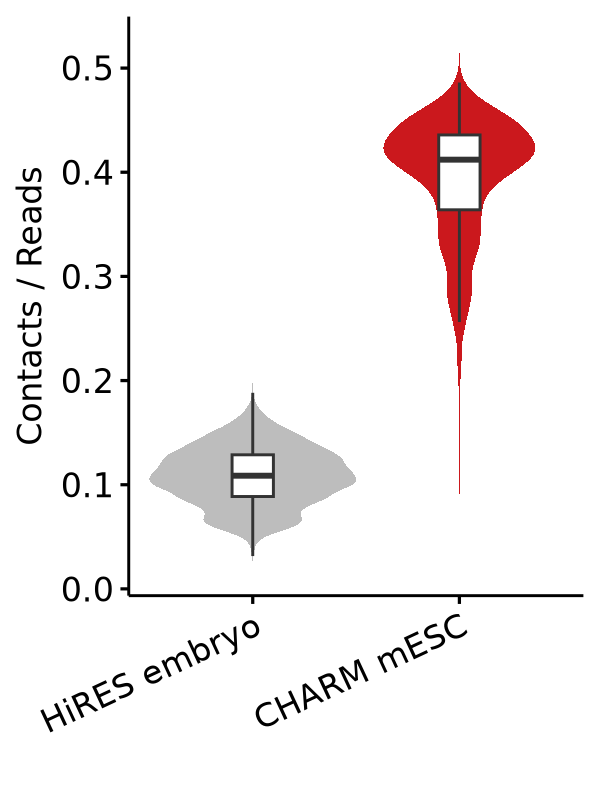

In [183]:
# violin plot of pairs per read
options(repr.plot.width=3, repr.plot.height=4,repr.plot.res=200)
rbind(
    hires[[]] %>% select(pairsPerRead) %>% mutate(method = "HiRES embryo"),
    charm[[]] %>% mutate(pairsPerRead = raw_pairs / (Rawreads * 1e9 / 300) ) %>% select(pairsPerRead) %>% select(pairsPerRead) %>% mutate(method = "CHARM mESC")
) %>%
    ggviolin(x="method",y="pairsPerRead",size=0,fill="method",palette = c("HiRES embryo" = cols[9],"CHARM mESC" = cols[10]))  +
    geom_boxplot(width=0.2,outlier.shape = NA) +
    xlab("") + ylab("Contacts / Reads") + NoLegend() + theme(axis.text.x = element_text(angle = 25, hjust = 1) ) 

ggsave("figures/CHARM_HiRESemb_pairsPerRead_violin.pdf",width=3,height=4)


## 3. 给RNA marker gene 着色

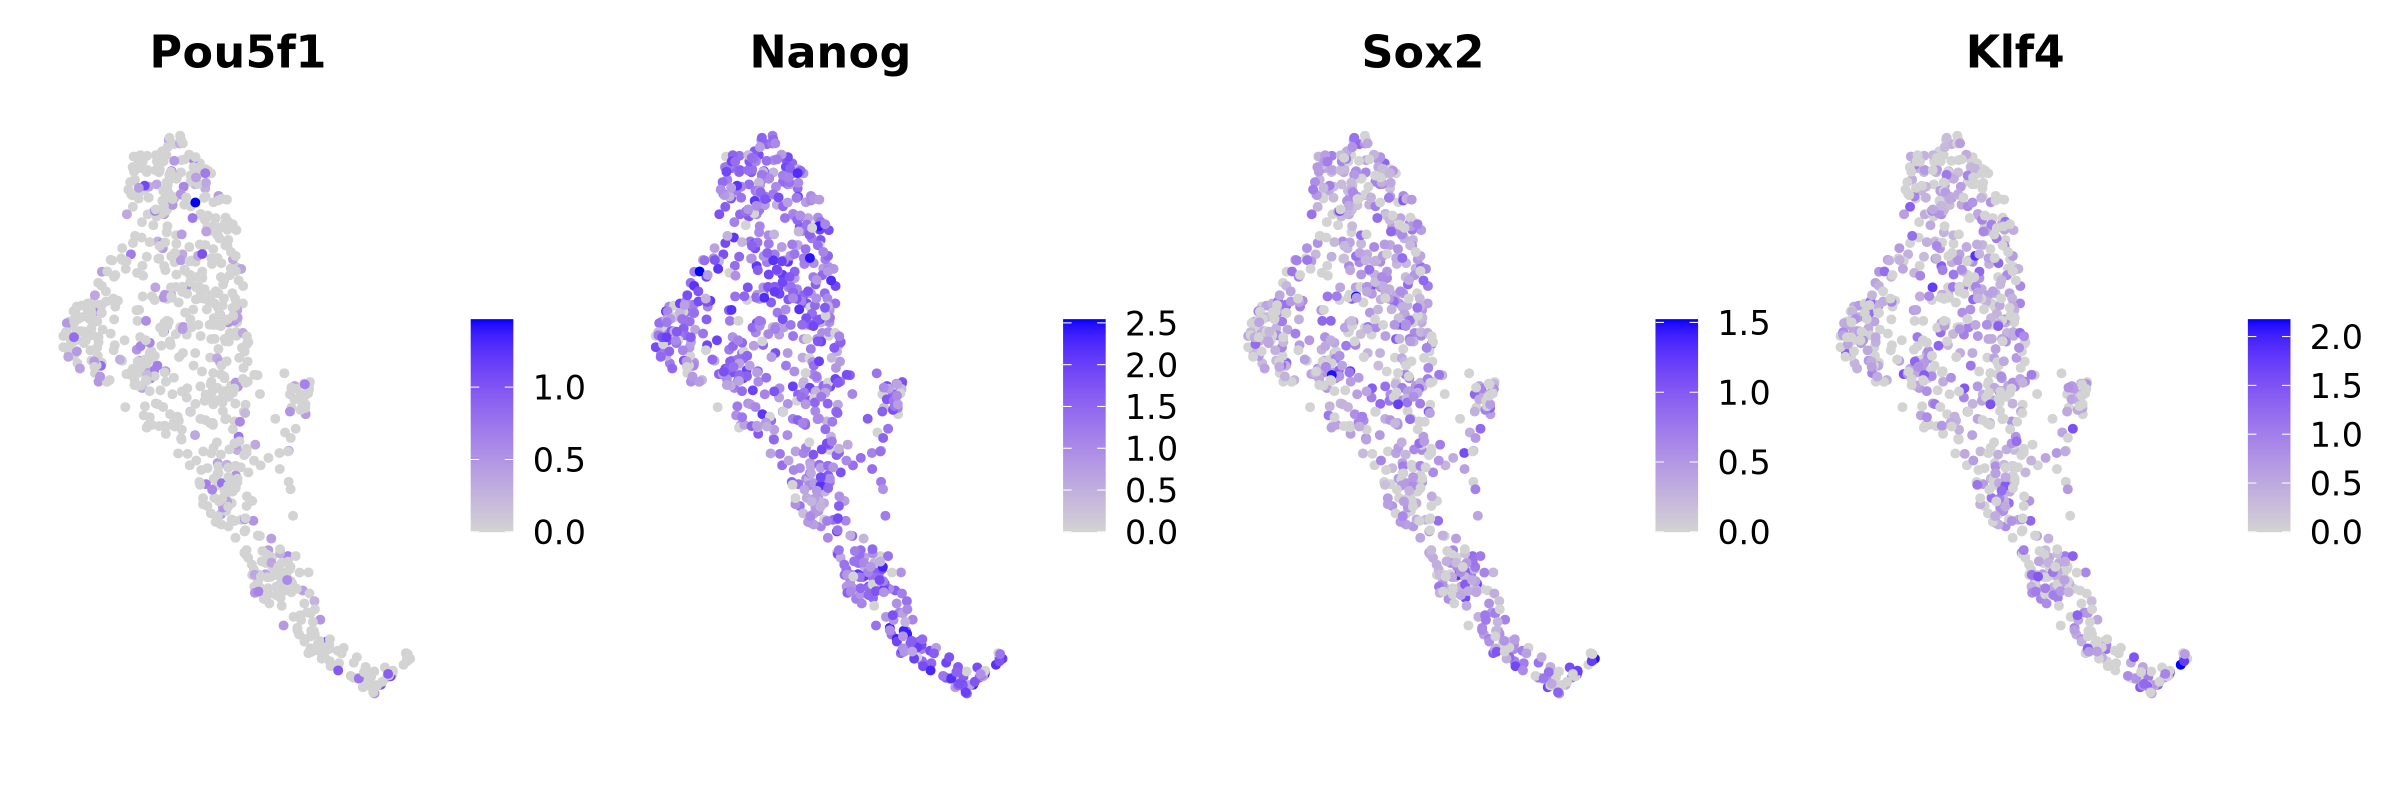

In [4]:
options(repr.plot.width=12, repr.plot.height=4,repr.plot.res=200)
FeaturePlot(charm,features = c("Pou5f1","Nanog","Sox2","Klf4"),ncol = 4) & NoAxes()
ggsave("figures/CHARM_mesc_marker_genes.pdf",width=12,height=4)

In [22]:
options(repr.plot.width=3, repr.plot.height=4,repr.plot.res=200)
VlnPlot(charm,features = c("Nanog","Sox2","Klf4"),ncol = 4,group.by = "orig.ident",stack=TRUE,flip = TRUE,cols = c("#eb5334","#eb5334","#eb5334")) & NoLegend() + 
    theme(axis.text.x = element_text(angle = 0, hjust = 90)) + xlab("") -> p

p %>% ggsave(filename = "figures/CHARM_mesc_marker_genes_vlnplot.pdf",width=3,height=4)


Warning message:
"'ncol' is ignored with 'stack' is TRUE"


Warning message in plot_theme(plot):
"The `x` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `x` theme element is not defined in the element hierarchy."
